# Poisson rSLDS 
## Behaving dataset
## Stim is as cue, system should come back to rest before lift 
## Fitting model from cue to grab, k=3

In [18]:
import ssm
from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import *

from scipy.ndimage import gaussian_filter1d

import random
import h5py

import fastplotlib as fpl

%matplotlib inline

In [2]:
path = f"/home/clewis/repos/realSpike/data/behavior/rb50_20250125/"

In [3]:
video_path =  Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/videos/")

# Get data

In [4]:
f = h5py.File("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/MAT_FILES/rb50_20250125_datastruct_pt3.mat", 'r')
data = f['data']
print(data.keys())

<KeysViewHDF5 ['aligned_cue_rec_time', 'aligned_laser_rec_time', 'any', 'chan_spk', 'cue', 'cue_rec_time', 'cue_trial_time', 'depth_spk', 'field_id', 'field_size', 'full_field', 'grab', 'grab_ms', 'laser', 'laser_rec_time', 'laser_trial_time', 'lift', 'lift_ms', 'lift_rec_time', 'mouth', 'mouth_ms', 'no_success', 'pattern_fill', 'pattern_id', 'pattern_xy', 'plift', 'plift_ms', 'single', 'spikes_raw_cue', 'spikes_raw_cue_extended', 'spikes_raw_laser', 'spikes_raw_lift', 'totTime', 'trial_start']>


# Plot the patterns

In [5]:
# visualize the patterns again
pattern_ids = list(np.unique(data['pattern_id'][:]))
len(pattern_ids)

30

In [6]:
from scipy.ndimage import zoom

In [7]:
reshape_size = 12

In [8]:
all_patterns = list()

for p_id in pattern_ids[3:]:
    ix = np.where(data['pattern_id'][:] == p_id)[1][0].astype(np.int32)
    pattern = np.zeros((data['pattern_xy'][0][ix].astype(np.int32), data['pattern_xy'][1][ix].astype(np.int32)))
    # use the pattern fill to set elements to one
    object_ref = f[data['pattern_fill'][ix, 0]]
    for x, y in zip(object_ref[0, :], object_ref[1, :]):
        pattern[x.astype(np.int32)-1, y.astype(np.int32)-1] = 1

    pattern = zoom(pattern, (reshape_size / pattern.shape[0], reshape_size / pattern.shape[1]), order=0)

    all_patterns.append(pattern)


In [9]:
len(all_patterns)

27

# Get single-reach trials

In [10]:
stim_idxs = np.where(data["pattern_id"][:] > 2)[1]
single_reach_idxs = np.where(data["single"][:, 0] == 1)

In [11]:
# get no laser trials
behavior_idxs = np.intersect1d(stim_idxs, single_reach_idxs)
behavior_idxs

array([ 18,  20,  23,  32,  37,  40,  42,  48,  55,  56,  60,  61,  67,
        68,  70,  78,  83,  86,  97, 101, 103, 106, 118, 121, 128, 131])

In [12]:
behavior_idxs.shape

(26,)

## Get relevant time information

In [17]:
cue_times = data["aligned_cue_rec_time"][behavior_idxs, :]
lift_times = data["lift_ms"][behavior_idxs, :]
grab_times = data["mouth_ms"][behavior_idxs, :]
(cue_times.shape, lift_times.shape, grab_times.shape)

((26, 1), (26, 1), (26, 1))

## Get the AP.bin file

In [19]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/rb50_20250125_g0/rb50_20250125_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/rb50_20250125_g0/rb50_20250125_g0_t0.imec0.ap.meta")

In [20]:
meta_data = get_meta(meta_path)

In [21]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 164723792)

## Get conversion params

In [26]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

(vmax, imax, gain)

(0.6, 512.0, 500.0)

# Get the model data

In [27]:
def get_trials(idxs, bin_size):
    
    model_data = list()
    
    for i in tqdm(range(len(idxs))):
        # 50 ms before cue
        cue_time = int((cue_times[i, 0] - 50) / 1_000 * 30_000)

        # end at grab 
        end_behavior = int((cue_times[i, 0] + grab_times[i, 0]) / 1_000 * 30_000)

        
        trial = ap_data[:150, cue_time:end_behavior]
    
        # convert to microvolts
        conv_data = 1e6 * trial / vmax / imax / gain
        # high pass filter 
        filt_data = butter_filter(conv_data, 1_000, 30_000)

        # get 1 second before the median 
        m_start = cue_time - (30 * 1000)
        # convert to microvolts, high pass filter
        trial_median = ap_data[:150, m_start:cue_time]
        trial_median = 1e6 * trial_median / vmax / imax / gain
        trial_median = butter_filter(trial_median, 1_000, 30_000)
        
        # calculate the median
        median = np.median(trial_median, axis=1)

        # get spike times
        spike_ixs, counts = get_spike_events(filt_data, median)
        
        a = np.zeros((filt_data.shape[0], filt_data.shape[1]))
    
        for i, sc in enumerate(spike_ixs):
            a[i, sc] = 1
    
        b = bin_size * 30 # 30ms per bin
        binned_spikes = bin_spikes(a, b)

        model_data.append(np.asarray(binned_spikes.T, dtype=int))

    return model_data

In [28]:
bin_size = 5

In [29]:
model_data = get_trials(behavior_idxs, bin_size)

100%|██████████████████████████████████████████████████████████████████████████| 26/26 [02:27<00:00,  5.66s/it]


In [30]:
model_data[0].shape

(116, 150)

In [32]:
# taking 50ms before cue, need to shift
cue = int(50 / bin_size)

lift = int(lift_times[0, 0] / bin_size) + cue

grab = int(grab_times[0, 0] / bin_size) + cue - 1

(lift, grab)

(72, 115)

### Sanity check the time points

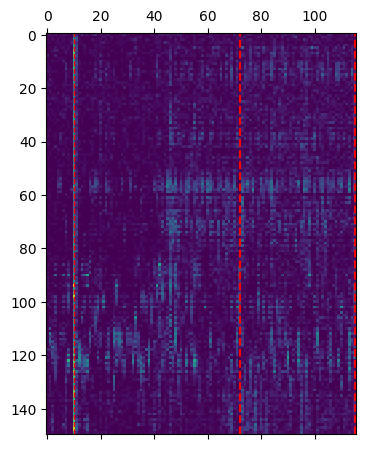

In [33]:
plt.matshow(model_data[0].T)
plt.axvline(cue, c="red", linestyle="--", lw=1)
plt.axvline(lift, c="red", linestyle="--")
plt.axvline(grab, c="red", linestyle="--")

# Design the input matrix

In [34]:
p_ids = np.unique(data["pattern_id"][0, behavior_idxs])

p_ids

array([14., 17., 20.])

## Get colors for plotting

In [56]:
c = {
    14: "blue",
    17: "orange",
    20: "green"
}

In [57]:
len(c)

3

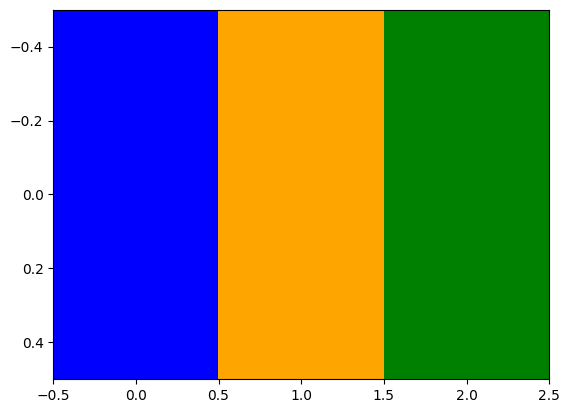

In [58]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(c.values())

plt.imshow(np.arange(len(c)).reshape(1,-1), aspect="auto", cmap=cmap)

# Create encodings 

In [54]:
import math

In [63]:
inputs = list()
colors = list()
for i, d in zip(stim_idxs, model_data):
    # get the pattern id 
    p_id = int(data["pattern_id"][0][i]) - 3

    colors.append(c[p_id + 3])

    encoding = all_patterns[p_id].ravel() 

    # stack the encoding for every timepoint (each bin)
    nput = np.zeros((d.shape[0], reshape_size**2))

    for z in range(math.ceil(5 / bin_size)):
        nput[int(50 / bin_size) + z] = encoding

    inputs.append(nput)

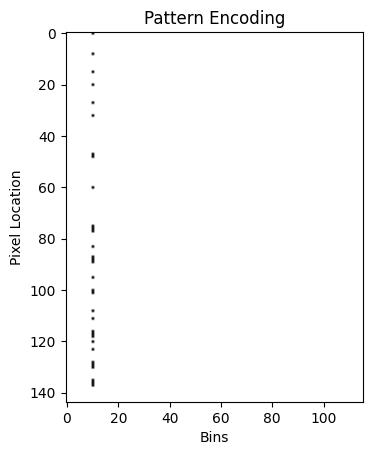

In [64]:
plt.imshow(inputs[0].T, cmap="binary")
plt.title("Pattern Encoding")
plt.xlabel("Bins")
plt.ylabel("Pixel Location")
plt.show()

# Fit the model

In [65]:
state_dim = 3
obs_dim = model_data[0].shape[1] 

plds = ssm.SLDS(N=obs_dim, 
                K=2, 
                D=state_dim, 
                M=144, 
                emissions="poisson", 
                emission_kwargs=dict(link="softplus"),
                dynamics="diagonal_gaussian",
                transitions="recurrent"
               )

elbos, q = plds.fit(model_data, inputs=inputs, method="laplace_em", num_iters=5)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [67]:
state_means = q.mean_continuous_states
len(state_means)

26

In [ ]:
# view a single trial
    # behavior (front and side) 
    # mean continuous state 
    # sampled mean continuous state 
    # heatmap of the binned spikes with linear selector 
    # synchronised with a slider 
# easy way to switch between trials

In [ ]:
# view all the trials 
    # somehow the sampling should make it smoother? 
    

In [68]:
lt = int(lift_times[0, 0] / bin_size) + 10
lt

72

In [69]:
lift_times.shape

(26, 1)

In [70]:
gt = int(grab_times[0, 0] / bin_size) + 10 - lt

In [71]:
gt

44

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [78]:
zhist = plds.most_likely_states(state_means[0], model_data[0], inputs[0])[lt]
zhist

np.int64(1)

In [79]:
xhist = state_means[0][lt, :]
xhist

array([ -1.18018478,   6.41884212, -31.18549021])

In [80]:
yhist = model_data[0][lt].reshape(1, 150)
yhist

array([[ 2,  1,  2,  1,  0,  2,  0,  0,  1,  0,  2,  1,  1,  2,  0,  4,
         1,  1,  0,  1,  0,  0,  2,  1,  0,  1,  1,  2,  0,  1,  3,  0,
         4,  1,  1,  3,  2,  9,  0,  6,  4,  4,  5,  1,  1,  0,  4,  2,
         0,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  1,
         0,  0,  3,  0,  3,  2,  7,  5,  2,  3,  1,  9,  1,  2,  2,  6,
         0,  4,  0,  3,  3,  2,  2,  9, 10,  8, 13,  6,  7,  4,  7,  5,
         3, 10, 11,  7, 15,  7, 18,  9, 11,  4, 14, 14,  8,  6,  5,  0,
         3,  1,  3,  5,  3,  3,  1,  2,  0,  0,  0,  0,  2,  0,  4,  0,
         1,  6,  1,  0,  0,  1,  1,  6,  1,  5,  3,  0,  0,  3,  1,  0,
         0,  1,  0,  1,  0,  0]])

In [81]:
np.concatenate(([zhist], np.zeros(5, dtype=int)))

array([1, 0, 0, 0, 0, 0])

In [82]:
xhist.shape

(3,)

In [83]:
plds.D

3

In [97]:
a = plds.sample(gt, prefix=[zhist, xhist.reshape(1,3), yhist], with_noise=True)

In [98]:
a

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([[ -0.90188097, -24.8221331 , -14.83866122],
        [ 24.99227669, -16.90369102,  -0.54695451],
        [ 11.07567692, -27.81191193,   0.59533572],
        [ -2.12381459,  -6.28474079, -16.70878882],
        [-15.7741014 ,   2.65473398,  -6.64659692],
        [ 26.12095472,   7.54069755,   3.12872777],
        [ 11.60822955, -16.63907824,  -7.11150998],
        [ 13.1403992 ,   2.49122148,   7.44860911],
        [ 24.73104225, -10.78182651,   8.17162434],
        [ -8.3972603 , -24.4269495 ,  -2.91211474],
        [ 24.2632515 , -17.07204242,  -1.51882   ],
        [  2.10352408,  -4.50039415, -23.20050969],
        [ 33.19266444, -31.33821406,  20.67261345],
        [ 14.10261987, -25.8006393 ,  11.23623752],
        [-12.73112022,   3.56224602,   3.35617425],
        [ 13.29766909, -20.92990608, -13.14593908],
        [  9.82811

In [99]:
a[1].T.shape

(3, 44)

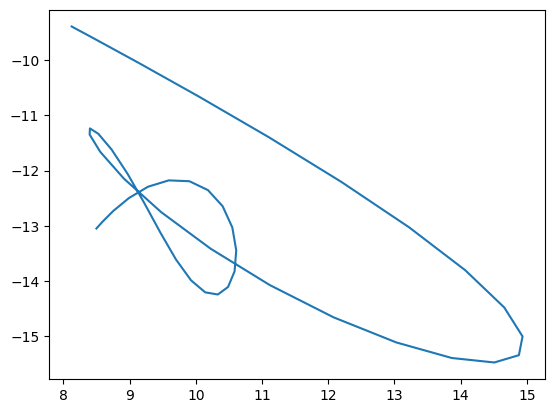

In [100]:
p = gaussian_filter1d(a[1].T, 5, axis=1)
plt.plot(p[0, :], p[1, :])